In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgboost
from sklearn import tree, metrics
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import tree

In [ ]:
gameData = pd.read_csv('finalData.csv', index_col=0)
for i in range(len(gameData)):
  gameData.iloc[i, 0] = datetime.strptime(gameData.iloc[i, 0], '%Y-%m-%d').date()
gameData.head()

,game_date,win/loss,ΔPE,ΔPE_10d,Log5,Whisnant,ΔOBP,ΔOBP_10d,ΔSLG,ΔSLG_10d,ΔWHIP,ΔWHIP_10d,ΔFIP,ΔRA_variance,ΔSP_ERA
0,2000-05-01,0.0,0.225534,0.349611,0.712574,0.626283,0.02680,0.03155,0.01638,0.09580,-0.1894,-0.21694,-0.28194,1.302627,1.32
1,2000-05-01,0.0,-0.117058,-0.017102,0.500000,0.492624,0.00194,0.00486,0.04238,0.05052,0.1129,0.44984,1.42348,0.761296,0.08
2,2000-05-01,0.0,-0.036871,0.168035,0.318179,0.588245,0.00175,0.01670,0.04014,0.02216,0.1786,0.09465,1.27970,-0.586304,0.73
3,2000-05-01,1.0,-0.133568,-0.031010,0.335589,0.515791,0.01755,-0.00729,0.00778,0.00353,0.3860,0.62353,1.29577,-0.378339,2.16
4,2000-05-01,0.0,-0.105874,-0.596740,0.482763,0.334315,-0.03854,-0.09203,-0.03875,-0.07553,0.0105,-0.03445,0.39801,0.419179,1.07


In [ ]:
def getYearIndex(dataframe, year):
  for i in range(len(dataframe)):
    if dataframe.iloc[i, 0].year == year:
      return i
      break

In [ ]:
trainingData = gameData[:getYearIndex(gameData, 2018)]
testingData = gameData[getYearIndex(gameData, 2018):]
X_train = trainingData.iloc[:, 2:]
y_train = trainingData['win/loss']
X_test = testingData.iloc[:, 2:]
y_test = testingData['win/loss']

Regularized Logistic Regression

In [ ]:
regularizationConstants = []
accuracies = []

for c in range(1,10,1):
  C = c/10
  logisticRegression = LogisticRegression(penalty = 'l2', C=C)
  k_folds = cross_val_score(logisticRegression, X_train, y_train, cv=8)
  regularizationConstants.append(C)
  accuracies.append(k_folds.mean())

best_C = regularizationConstants[accuracies.index(max(accuracies))]

In [ ]:
logisticRegression = LogisticRegression(penalty = 'l2', C=best_C)
logisticRegression.fit(X_train, y_train)
predictions = logisticRegression.predict(X_test)
print('Logistic Regression Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[:4] + '%')

Logistic Regression Accuracy: 58.9%


Random Forest Model

In [ ]:
# Hyperparameter Tuning
prev_accuracy = .5
optimal_tree_num = 0
optimal_depth = 0
optimal_criteria = ''
optimal_split = 0
optimal_features = 0
for num_trees in [25, 40, 60, 90, 120, 300]:
  for depth in range(4,8):
    for max_features in range(3,6):
      for criteria in ['gini', 'entropy']:
        for split in [10, 15, 20, 50, 80, 120]:
          forest = RandomForestClassifier(n_estimators=num_trees, criterion=criteria, \
            max_features=max_features, min_samples_split=optimal_split, max_depth=depth)
          k_folds = cross_val_score(forest, X_train, y_train, cv=8)
          if k_folds.mean() > prev_accuracy:
            optimal_tree_num = num_trees
            optimal_depth = depth
            optimal_criteria = criteria
            optimal_features = max_features
            optimal_split = split

In [ ]:
# grid search
n_estimators = [90, 150, 200, 400]
criterion = ['entropy', 'gini']
max_features = [3,4, 'sqrt']
max_depth = [4,5,6,7,8] 
min_samples_split = [10,45,70]

param_grid = {'n_estimators': n_estimators,
              'criterion' : criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split}

randomForest = RandomForestClassifier()
grid = GridSearchCV(estimator=randomForest, param_grid=param_grid, cv=12, verbose=4, n_jobs=4)
grid.fit(X_train, y_train)

In [201]:
randomForest = RandomForestClassifier(n_estimators=optimal_tree_num, criterion=optimal_criteria, \
  max_features=max_features, min_samples_split=optimal_split, max_depth=depth)
randomForest.fit(X_train, y_train)
predictions = randomForest.predict(X_test)
print("Vegas Odds Accuracy: " + str(100*Vegas2018_19Accuracy['right/wrong'].sum()/len(Vegas2018_19Accuracy['right/wrong']))[:4] + '%')
print('-----------------------------')
print('Random Forest Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[:4] + '%')

Vegas Odds Accuracy: 59.4%
-----------------------------
Random Forest Accuracy: 59.6%


Text(0.5, 1.0, 'Random Forest Feature Importance')

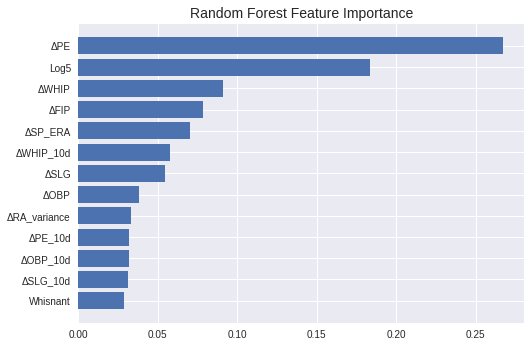

In [ ]:
sorted = randomForest.feature_importances_.argsort()
plt.barh(X_train.columns[sorted], randomForest.feature_importances_[sorted])
plt.title('Random Forest Feature Importance', fontsize=14)

XG Boost Model

In [202]:
XG = xgboost.XGBClassifier(learning_rate=.00000001, max_depth=7, subsample=.8, colsample_bytree=.3, n_estimators=1000)
XG.fit(X_train, y_train)
predictions = XG.predict(X_test)
print('XG Boost Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[:4] + '%')

XG Boost Accuracy: 59.6%


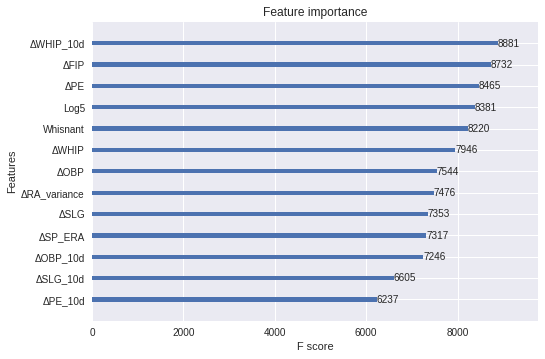

In [ ]:
xgboost.plot_importance(XG)
plt.style.use('seaborn')

Support Vector Machine

In [ ]:
SVM = SVC()
SVM.fit(X_train, y_train)
predictions = SVM.predict(X_test)
print('Support Vector Machine Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[0:4] + '%')

Support Vector Machine Accuracy: 53.1%


Decision Tree

In [ ]:
decisionTree = DecisionTreeClassifier(max_depth=5)
decisionTree.fit(X_train,y_train)
pred = decisionTree.predict(X_test)
print('Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, pred),3), 3)) + '%')

Accuracy: 57.6%


Text(0.5, 1.0, 'Decision Tree Feature Importance')

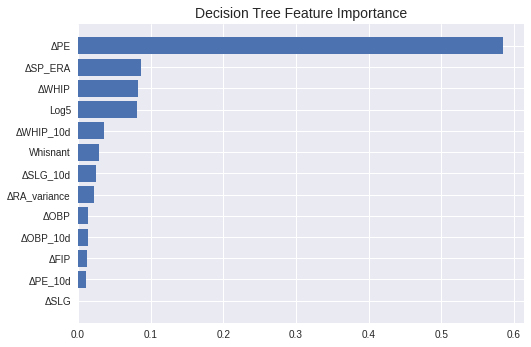

In [ ]:
sorted = decisionTree.feature_importances_.argsort()
plt.barh(X_train.columns[sorted], decisionTree.feature_importances_[sorted])
plt.title('Decision Tree Feature Importance', fontsize=14)

Import New Dataframe That Includes Vegas Betting Odds Data (Web Scraped)

In [ ]:
data = data = pd.read_csv('VegasOddsIncluded.csv', index_col=0)
for i in range(len(data)):
  data.iloc[i, 0] = datetime.strptime(data.iloc[i, 0], '%Y-%m-%d').date()
model = data.copy()

In [ ]:
Vegas2019Accuracy = data[getYearIndex(data, 2019):]
Vegas2018_19Accuracy = data[getYearIndex(data, 2018):]
print("'14-'19 Vegas Odds Accuracy: " + str(100*data['right/wrong'].sum()/len(data['right/wrong']))[:4] + '%')
print('-----------------------------------')
print("'18-'19 Vegas Odds Accuracy: " + str(100*Vegas2018_19Accuracy['right/wrong'].sum()/len(Vegas2018_19Accuracy['right/wrong']))[:4] + '%')
print('-----------------------------------')
print("'19 Vegas Odds Accuracy: " + str(100*Vegas2019Accuracy['right/wrong'].sum()/len(Vegas2019Accuracy['right/wrong']))[:4] + '%')

'14-'19 Vegas Odds Accuracy: 58.2%
-----------------------------------
'18-'19 Vegas Odds Accuracy: 59.4%
-----------------------------------
'19 Vegas Odds Accuracy: 60.3%


In [ ]:
del model['Vegas_Odds']
del model['home_moneyline']
del model['home_team']
del model['opponent']
del model['home_score']
del model['away_score']
del model['away_team']
del model['outcome']
del model['prediction']
del model['right/wrong']

In [ ]:
model.tail()

,date,win/loss,ΔPE,ΔPE_10d,Log5,Whisnant,ΔOBP,ΔOBP_10d,ΔSLG,ΔSLG_10d,ΔWHIP,ΔWHIP_10d,ΔFIP,ΔSP_ERA,ΔRA_variance,moneyline
17950,2019-09-29,1.0,0.171002,-0.107356,0.678307,0.592622,0.02876,-0.01592,0.05014,-0.04985,-0.0754,0.26351,-1.27734,-3.91,0.831274,0.754300
17951,2019-09-29,1.0,-0.032996,0.154866,0.424606,0.465258,-0.00857,0.00797,-0.01039,0.06714,-0.0515,0.07389,-0.30324,1.70,-0.103719,0.534884
17952,2019-09-29,1.0,-0.139157,0.092240,0.319915,0.472948,-0.02113,0.01019,-0.00425,0.03649,0.2598,0.36434,1.19332,2.79,-0.398356,0.341297
17953,2019-09-29,1.0,-0.152471,-0.103326,0.340449,0.427517,-0.02087,0.01428,-0.06016,-0.00498,0.1644,0.53308,0.38177,-0.48,-0.551985,0.425532
17954,2019-09-29,1.0,0.006089,0.218370,0.493649,0.552652,0.01768,0.07554,0.02091,0.07887,0.0728,-0.29885,0.08420,3.51,-0.156093,0.400000


In [ ]:
# only have betting Odds going back to 2014
trainingData = model[getYearIndex(model, 2014):getYearIndex(model, 2019)]
testingData = model[getYearIndex(model, 2019):]
X_train = trainingData.iloc[:, 2:]
y_train = trainingData['win/loss']
X_test = testingData.iloc[:, 2:]
y_test = testingData['win/loss']

In [ ]:
logReg = LogisticRegression(penalty = 'l2', C=.8)
logReg.fit(X_train, y_train)
predictions = logReg.predict(X_test)
print('Logistic Regression Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3)) + '%')

Logistic Regression Accuracy: 60.5%


In [ ]:
randomForest = RandomForestClassifier(n_estimators=optimal_tree_num, criterion=optimal_criteria, \
  max_features=max_features, min_samples_split=optimal_split, max_depth=depth)
randomForest.fit(X_train, y_train)
predictions = randomForest.predict(X_test)
scores.append(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))
print('Random Forest Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3)) + '%')

Random Forest Accuracy: 61.1%
